In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

Used this entire code for generating data for the vander pol differential equation and saving it in .mat file

In [51]:
# def van_der_pol(t, y, mu):
#     dydt = [y[1], mu * (1 - y[0]**2) * y[1] - y[0]]
#     return dydt

# def generate_vdp_data(mu, num_samples, t_span, t_values):
#     X = []
#     Y = []
#     for _ in range(num_samples):
#         y0 = [np.random.uniform(-2, 2), np.random.uniform(-2, 2)]  
#         sol = solve_ivp(van_der_pol, t_span, y0, args=(mu,), t_eval=t_values)

#         y_values = sol.y[0]  # y(t)
#         v_values = sol.y[1]  # v(t)

#         dvdt = mu * (1 - y_values**2) * v_values - y_values
#         X.extend(np.column_stack((t_values, y_values, v_values)))
#         Y.extend(dvdt)

#     return np.array(X), np.array(Y)

# mu = 5  
# num_samples = 1000 
# t_span = (0, 20)  
# t_values = np.linspace(0, 20, 500)

# X_train, Y_train = generate_vdp_data(mu, num_samples, t_span, t_values)

# scipy.io.savemat('vanderpol_training_data.mat', {'X_train': X_train, 'Y_train': Y_train})


Imported data from the .mat file and extracted the necessary variables for training, converted them to tensor

In [29]:
data = scipy.io.loadmat('vanderpol_training_data.mat')
X_train = data['X_train']  
Y_train = data['Y_train'].reshape(-1,1) 

In [30]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)

In [31]:
X_train_tensor.shape

torch.Size([500000, 3])

In [32]:
Y_train_tensor.shape

torch.Size([500000, 1])

Defined model for training a deep neural network to solve the differential equation

In [33]:
class VanDerPolNN(nn.Module):
    def __init__(self):
        super(VanDerPolNN, self).__init__()
        self.fc1 = nn.Linear(3, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Training of the model

In [34]:
model = VanDerPolNN()

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

epochs = 1000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_tensor)
    loss = criterion(predictions, Y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

torch.save(model.state_dict(), 'vanderpol_model.pth')


Epoch 100/1000, Loss: 44.196834564208984
Epoch 200/1000, Loss: 3.223898410797119
Epoch 300/1000, Loss: 1.2213282585144043
Epoch 400/1000, Loss: 0.7585311532020569
Epoch 500/1000, Loss: 0.5241521596908569
Epoch 600/1000, Loss: 0.39230582118034363
Epoch 700/1000, Loss: 0.3542283773422241
Epoch 800/1000, Loss: 0.2542218267917633
Epoch 900/1000, Loss: 0.21204005181789398
Epoch 1000/1000, Loss: 0.17931991815567017


Made a dataset to test our model for values of time after the value upto which we trained the model

In [54]:
def van_der_pol(t, y, mu):
    dydt = [y[1], mu * (1 - y[0]**2) * y[1] - y[0]]
    return dydt

mu=5
t_values_test = np.linspace(20, 100, 500) 

initial_conditions = [X_train[-1, 1], X_train[-1, 2]]  
sol_test = solve_ivp(van_der_pol, t_span_test, initial_conditions, args=(mu,), t_eval=t_values_test)

y_test = sol_test.y[0]  
v_test = sol_test.y[1] 

In [55]:
X_test = np.column_stack((t_values_test, y_test, v_test)) 
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)


model.eval()  
predictions_test = model(X_test_tensor).detach().numpy()
dvdt_test_true = mu * (1 - y_test**2) * v_test - y_test


Plotted the outcome and compared it with the original solution of the equations

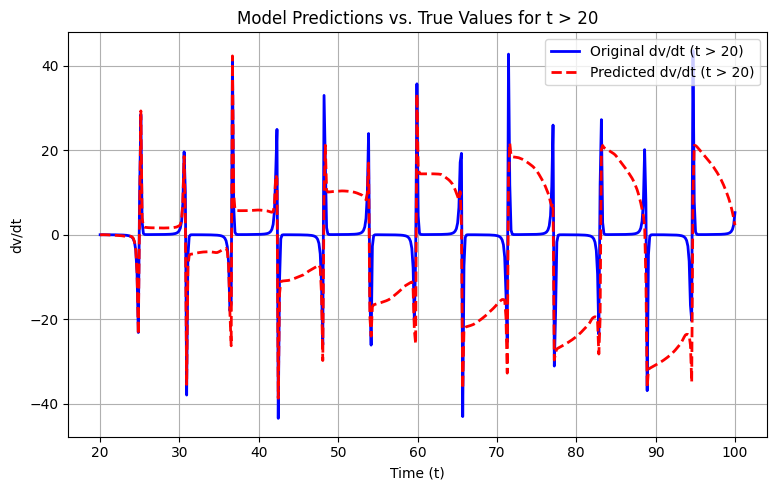

In [56]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 2)
plt.plot(t_values_test, dvdt_test_true, label='Original dv/dt (t > 20)', color='blue', linewidth=2)
plt.plot(t_values_test, predictions_test, label='Predicted dv/dt (t > 20)', color='red', linestyle='--', linewidth=2)
plt.title('Model Predictions vs. True Values for t > 20')
plt.xlabel('Time (t)')
plt.ylabel('dv/dt')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()